In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [6]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder

DIRECTORY = "../data/huge-page-access-compression-test"

# A structure for storing the data
all_data = {}

for i in range(500, 600):
    if os.path.isfile(f"{DIRECTORY}/{i}-lzo.csv"):
        all_data[i] = pd.read_csv(f"{DIRECTORY}/{i}-lzo.csv")
        print(f"Loaded data for test {i}")

Loaded data for test 500
Loaded data for test 502
Loaded data for test 508
Loaded data for test 511
Loaded data for test 519
Loaded data for test 521
Loaded data for test 525
Loaded data for test 531
Loaded data for test 538
Loaded data for test 544
Loaded data for test 548


Done with test 500
Done with test 502
Done with test 508
Done with test 511
Done with test 519
Done with test 521
Done with test 525
Done with test 531
Done with test 538
Done with test 544
Done with test 548


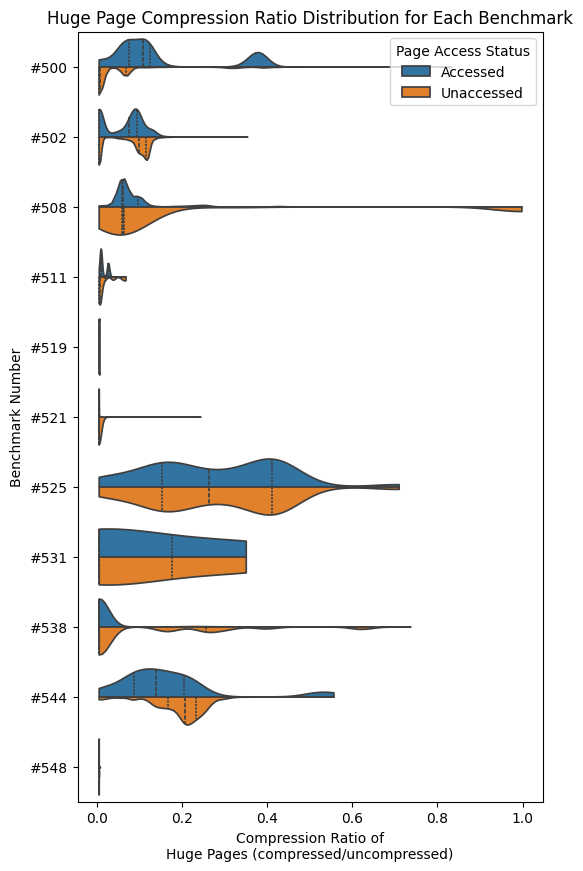

In [7]:
plt.figure(figsize=(6, 10))
all_tests = pd.DataFrame()
for test_number in all_data.keys():
    test_data = all_data[test_number]
    # Show a violin graph with the compression ratio for each page throughout all intervals
    # Get the compressed sizes of the pages by getting their compression savings in bytes, and subtracting that from the page size (4096)
    # test_data["Compressed Size"] = 4096 - test_data["Compression Savings (bytes)"]
    # Get the compression ratio by dividing the compressed size by the original size
    # test_data["Compression Ratio"] = test_data["Compressed Size"] / 4096
    # Add the test number to the data
    test_data["Benchmark Number"] = f"#{test_number}"
    
    # print("Average compression ratio for test", test_number, ":", test_data["Compression Ratio"].mean())
    # print("Average saved bytes for test", test_number, ":", test_data["Compression Savings (bytes)"].mean())
    all_tests = pd.concat([all_tests, test_data])
    print("Done with test", test_number)

ax = sns.violinplot(data=all_tests, cut=0, x="Compression Ratio (compressed/uncompressed)", y="Benchmark Number", hue="Unaccessed?", inner="quartile", split=True, density_norm="width")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Accessed", "Unaccessed"], title="Page Access Status")
# Label with the test number

plt.xlabel("Compression Ratio of\nHuge Pages (compressed/uncompressed)")
plt.ylabel("Benchmark Number")
plt.title("Huge Page Compression Ratio Distribution for Each Benchmark")
# plt.legend(title="Page Access Status")
plt.show()

Test 500


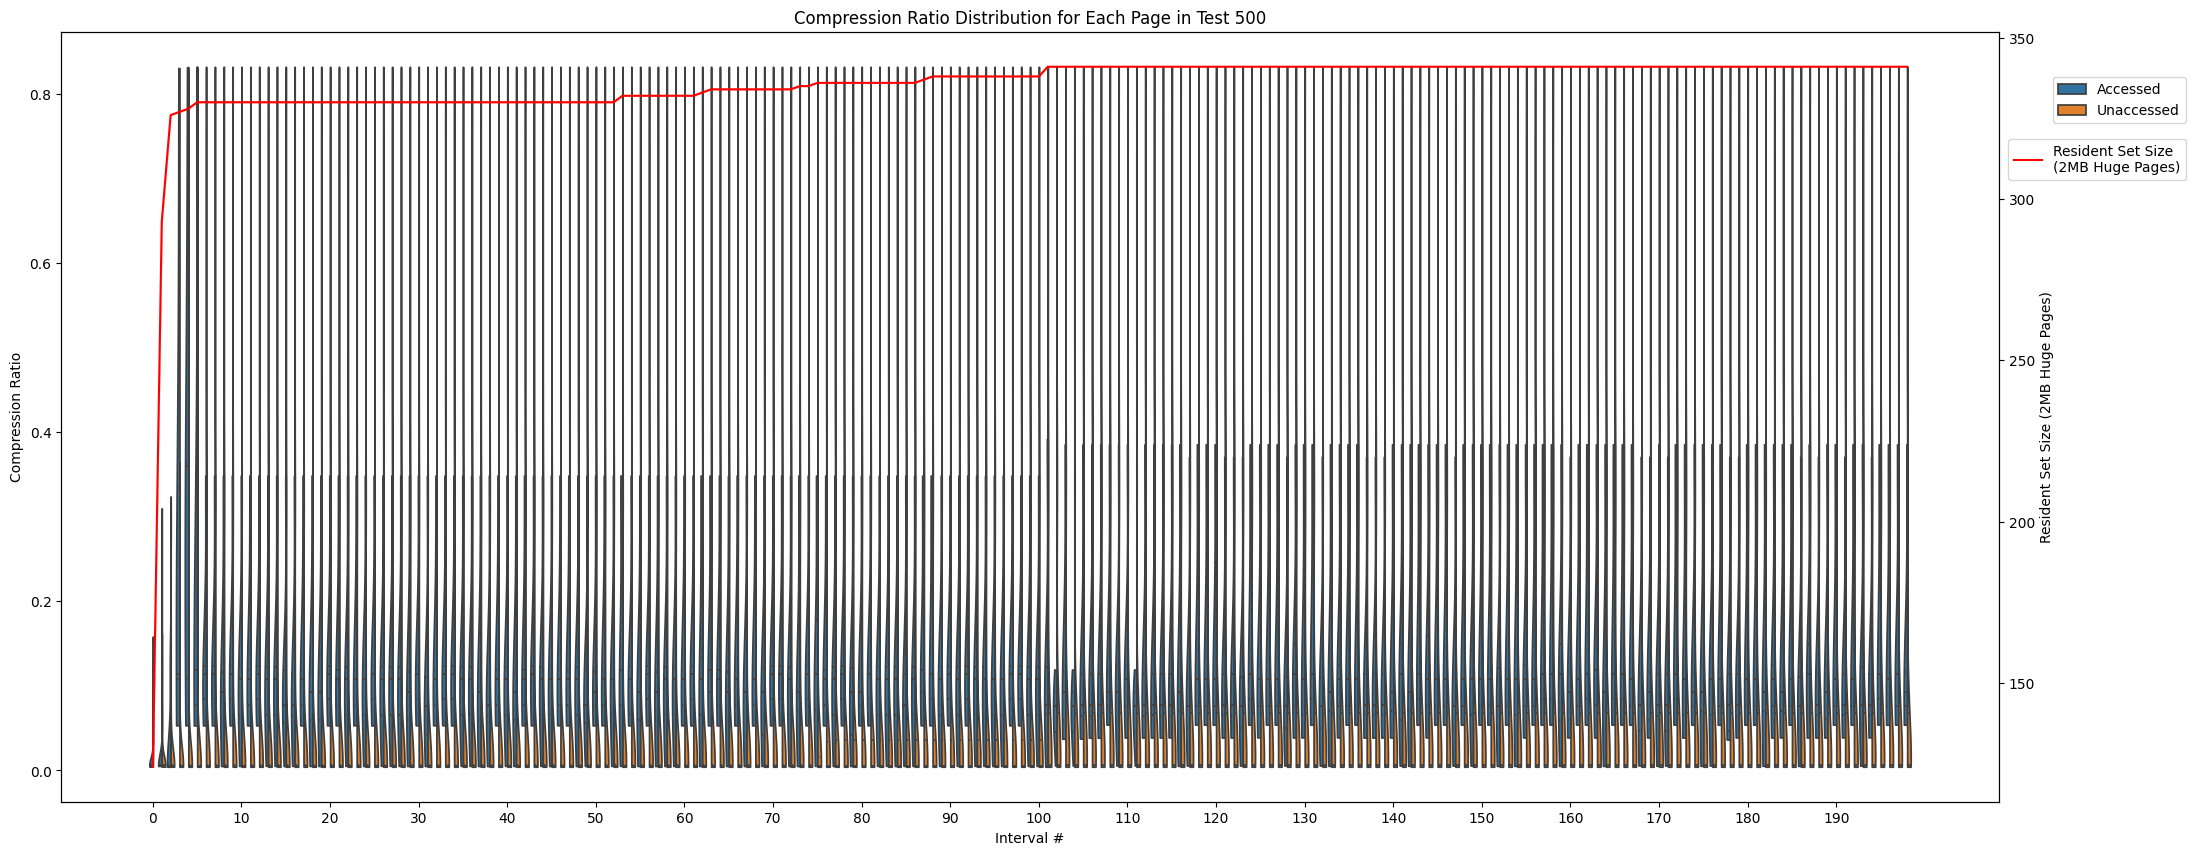

Test 502


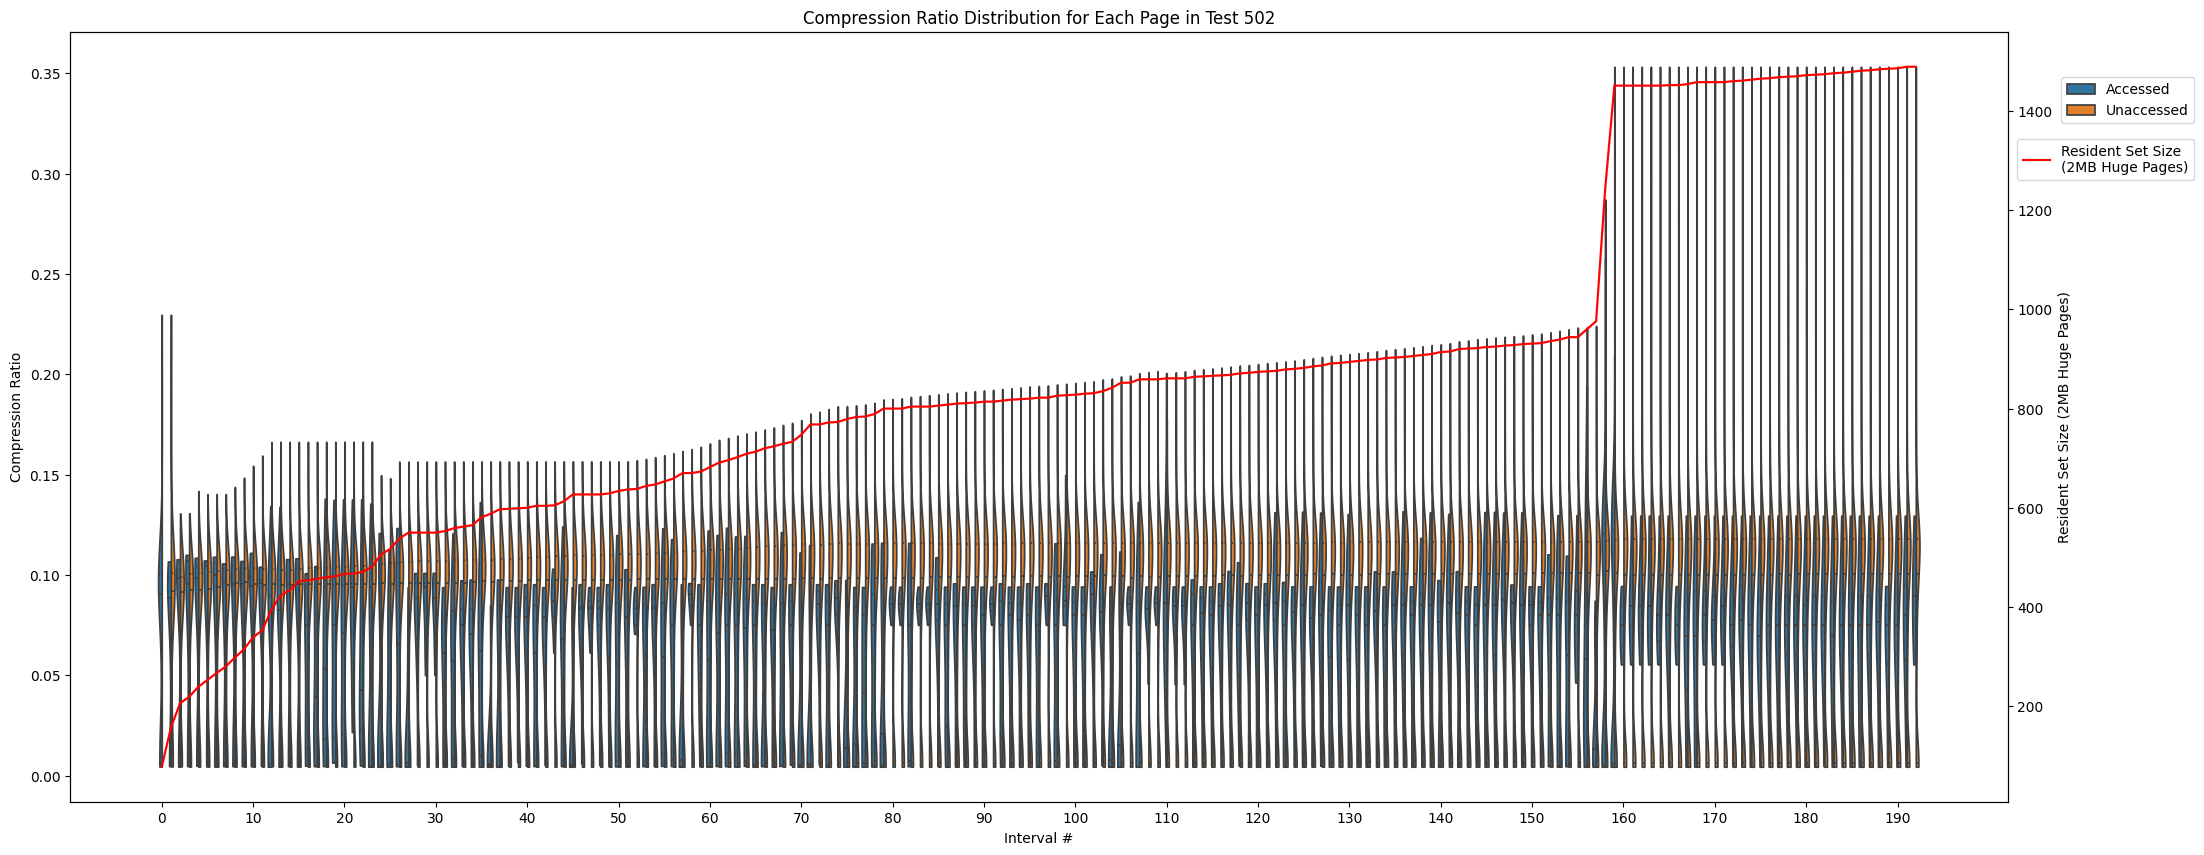

Test 508


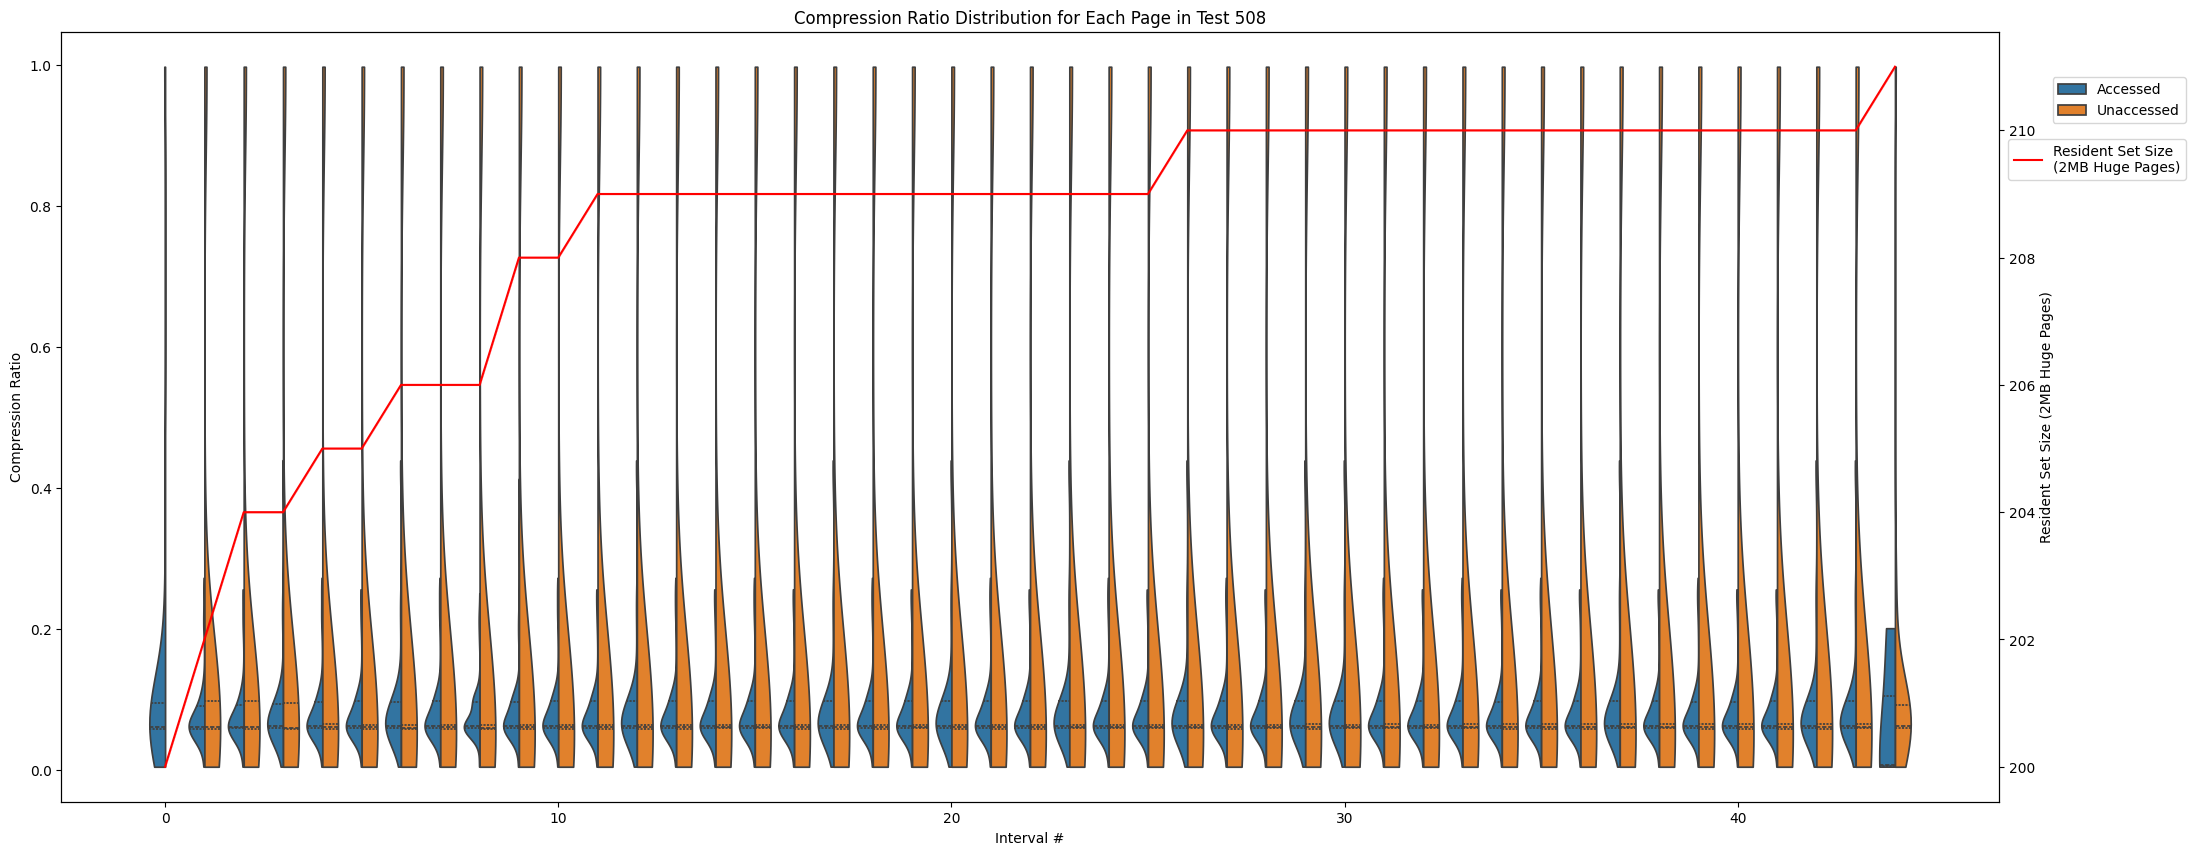

Test 511


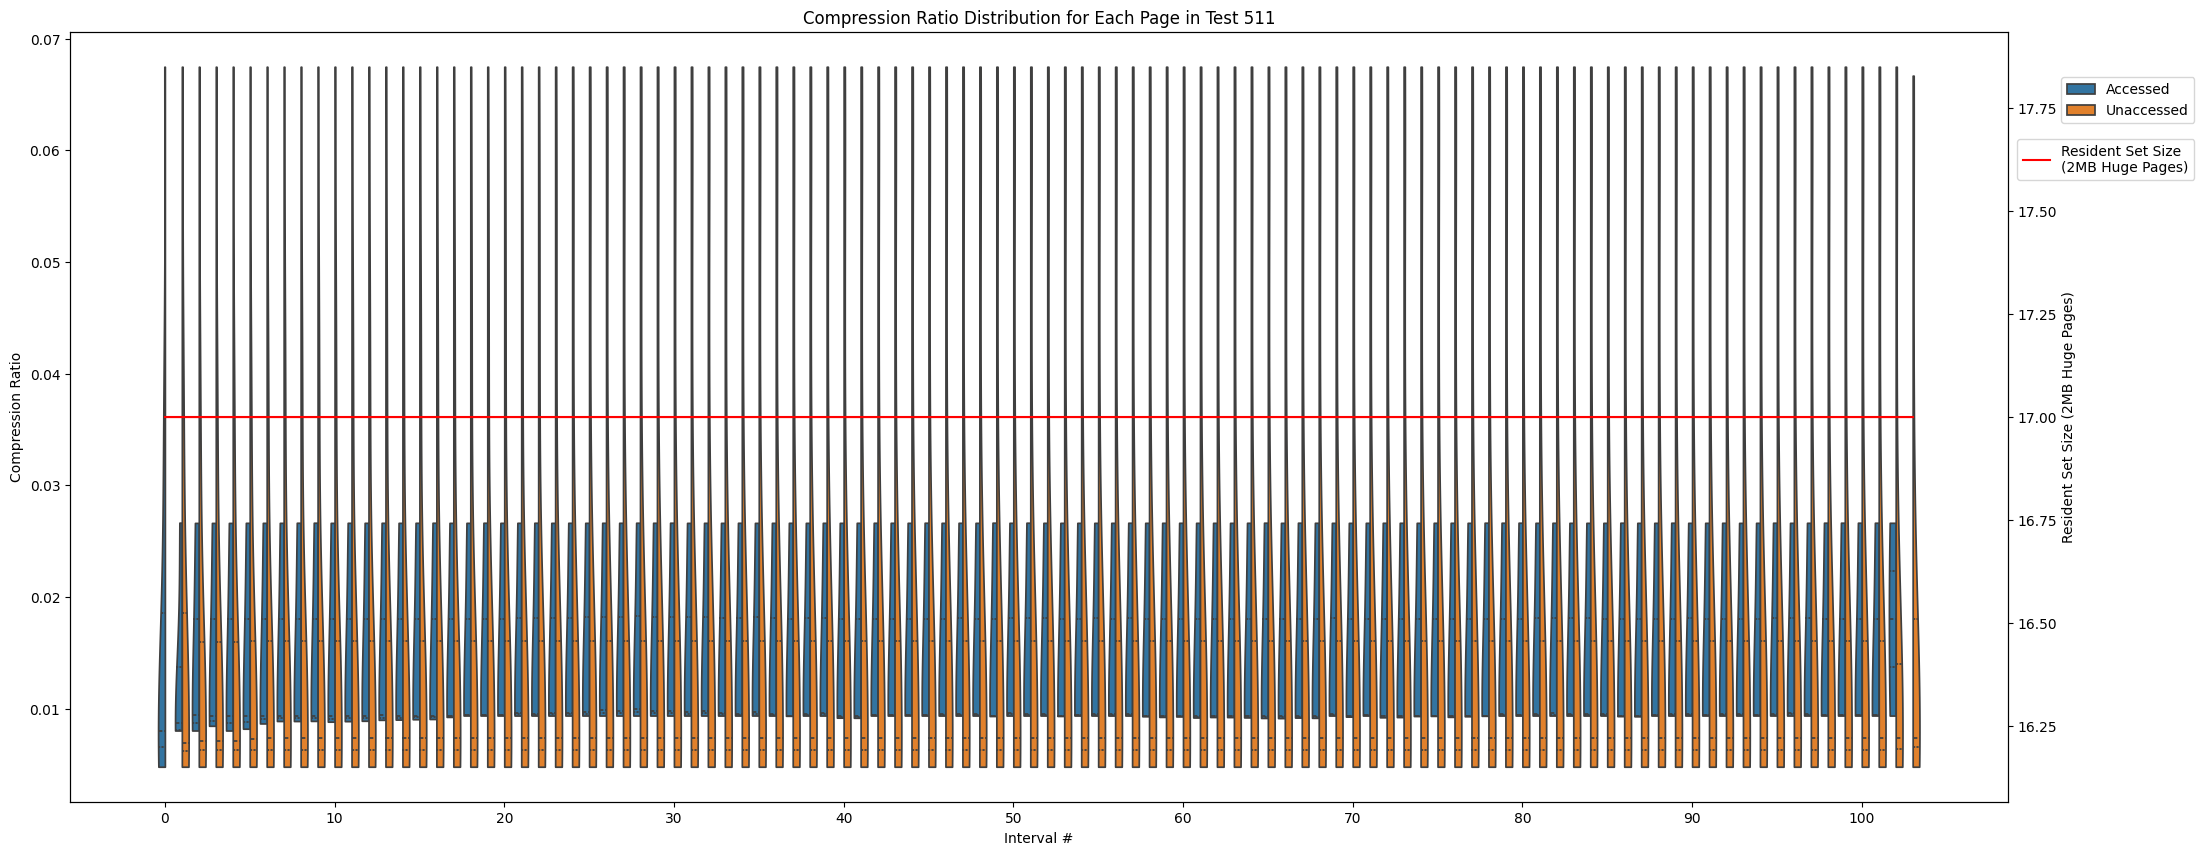

Test 519


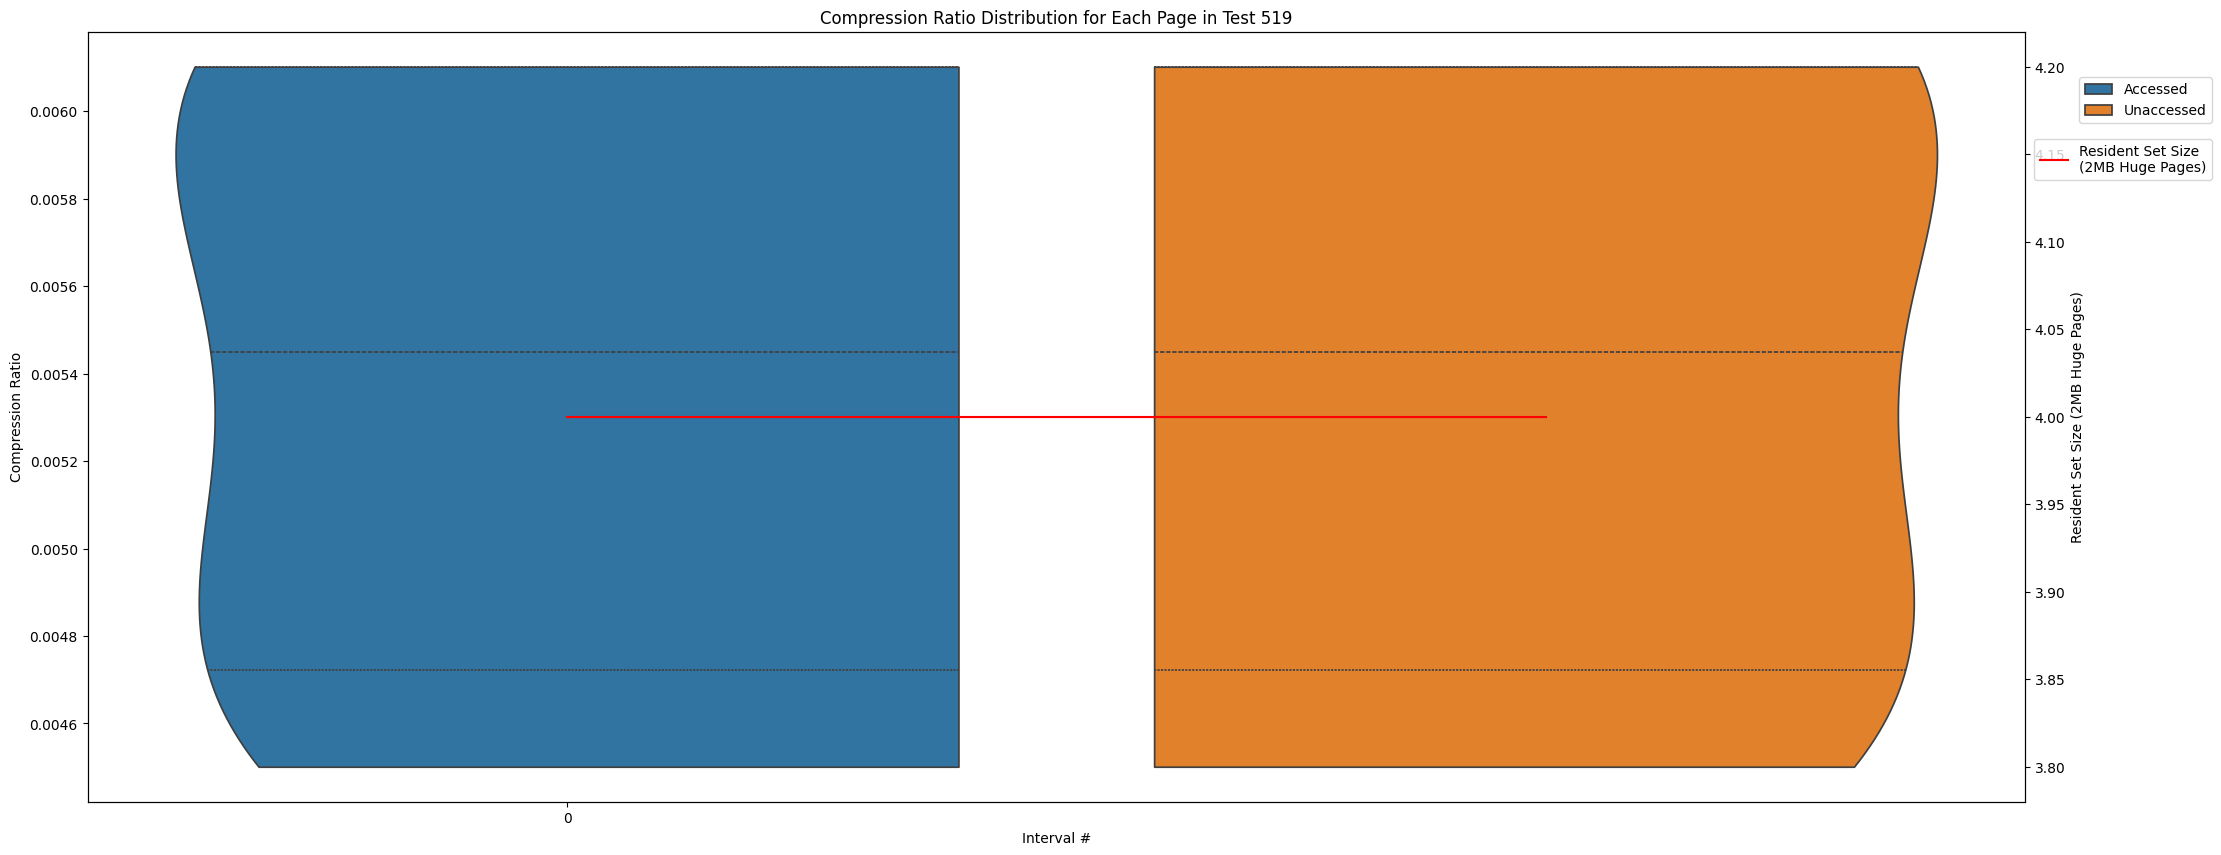

Test 521


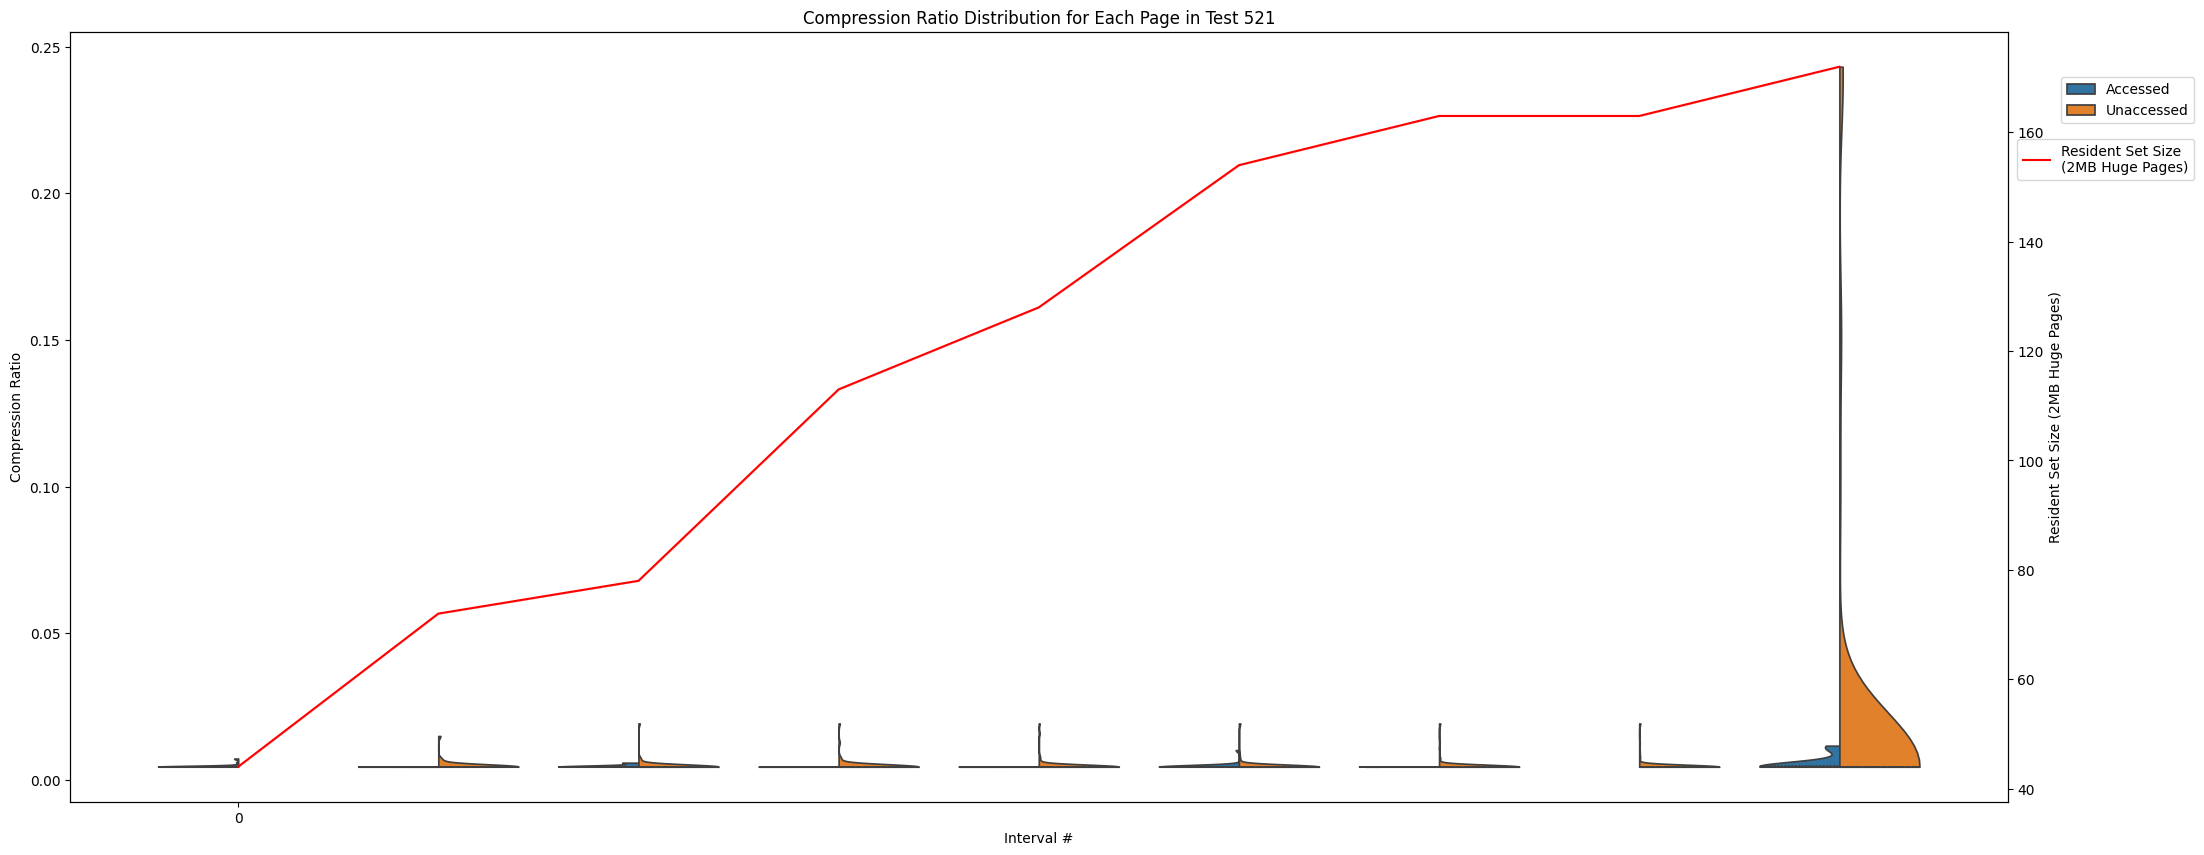

Test 525


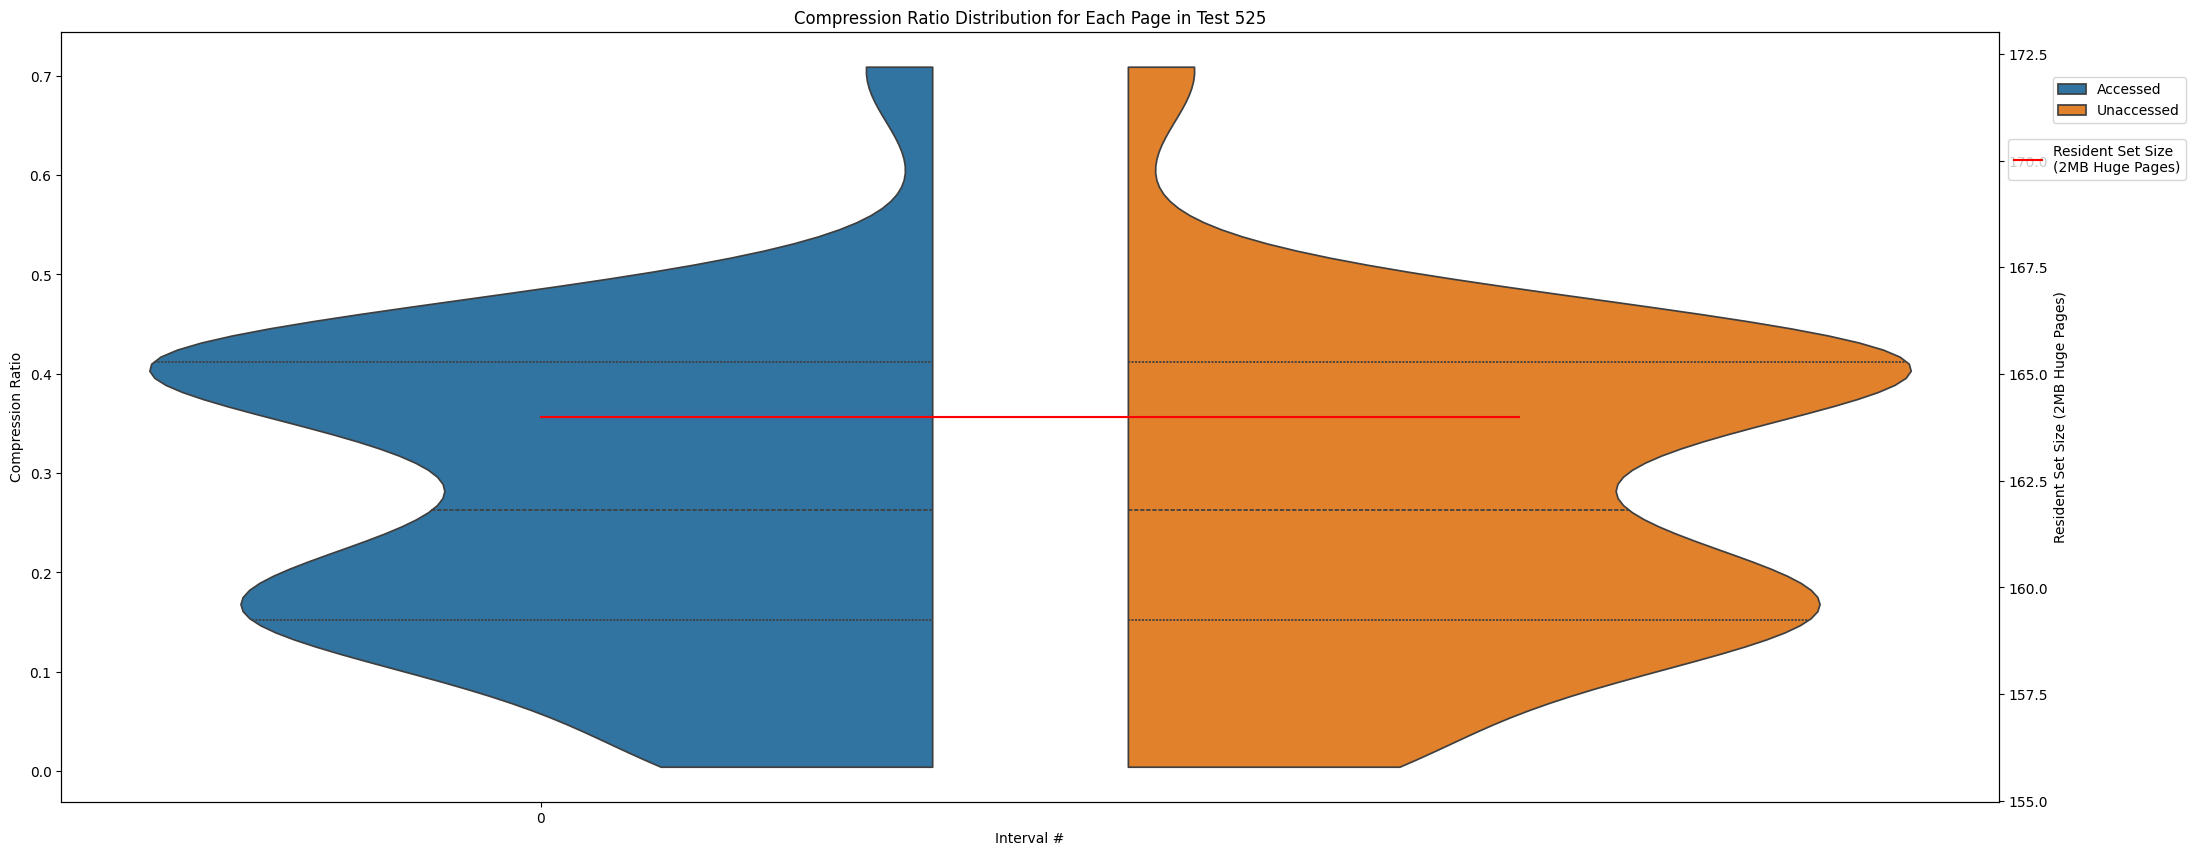

Test 531


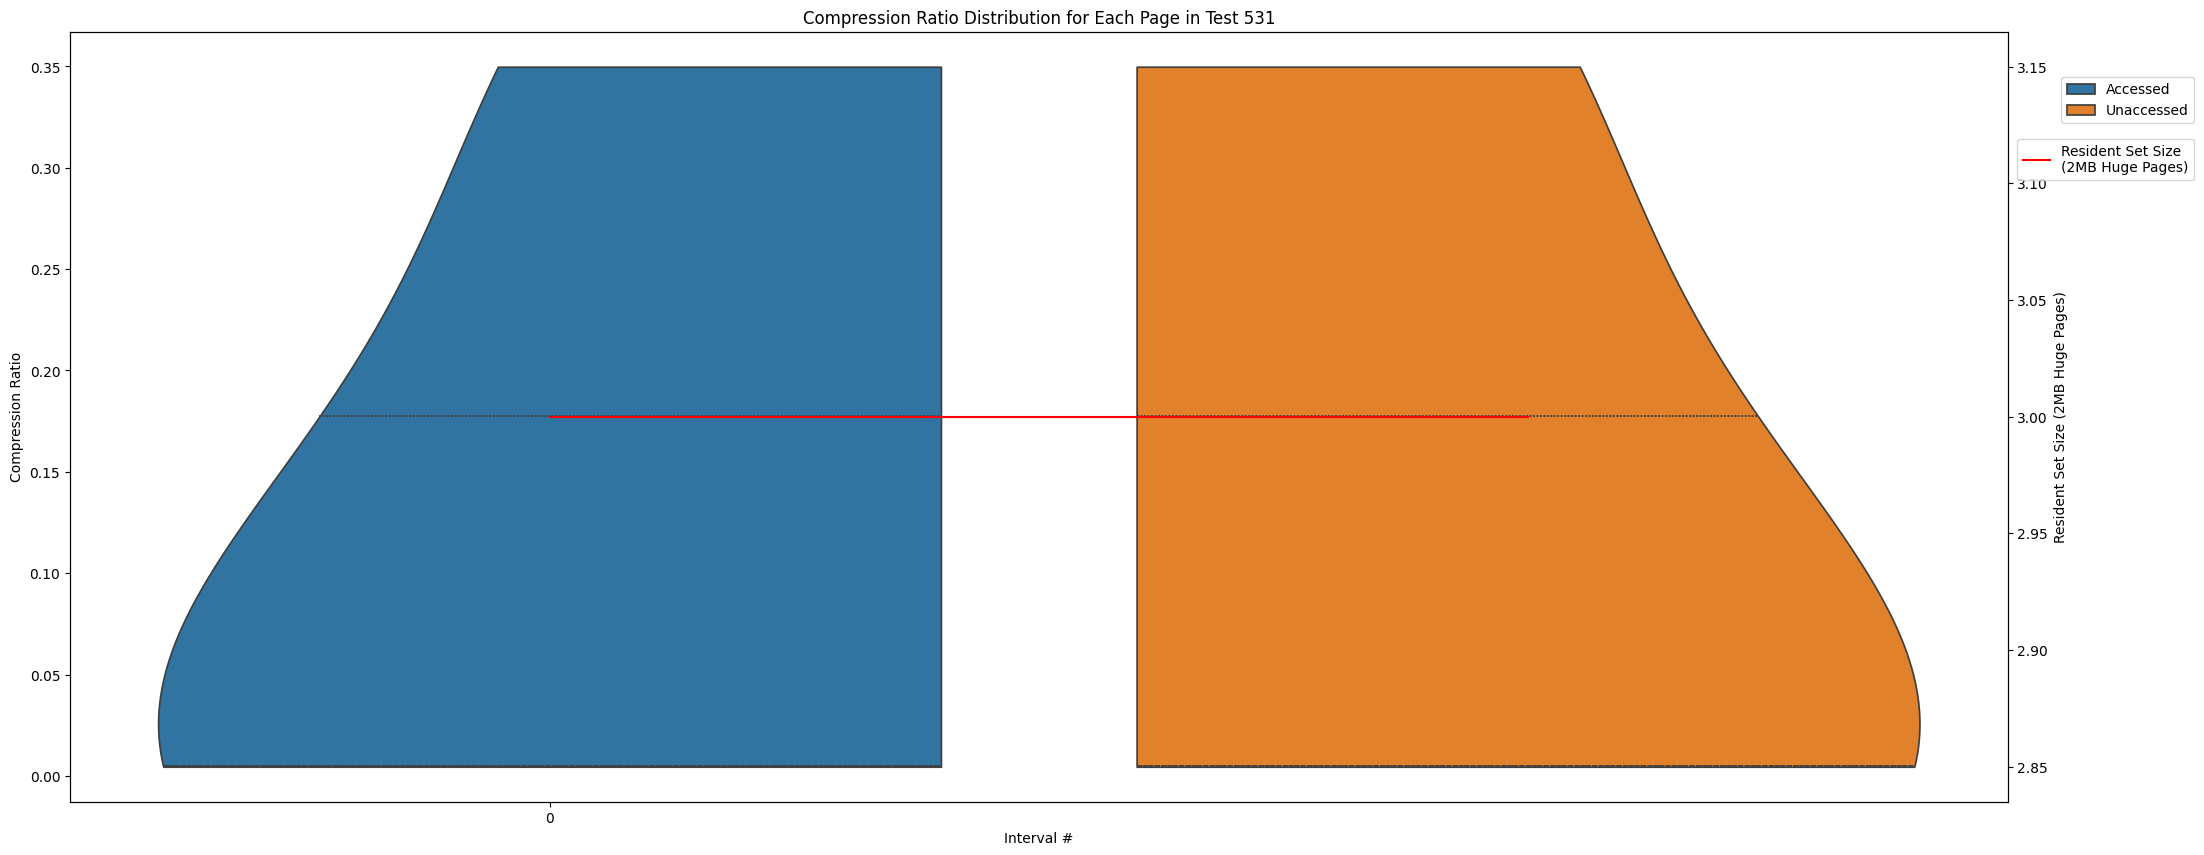

Test 538


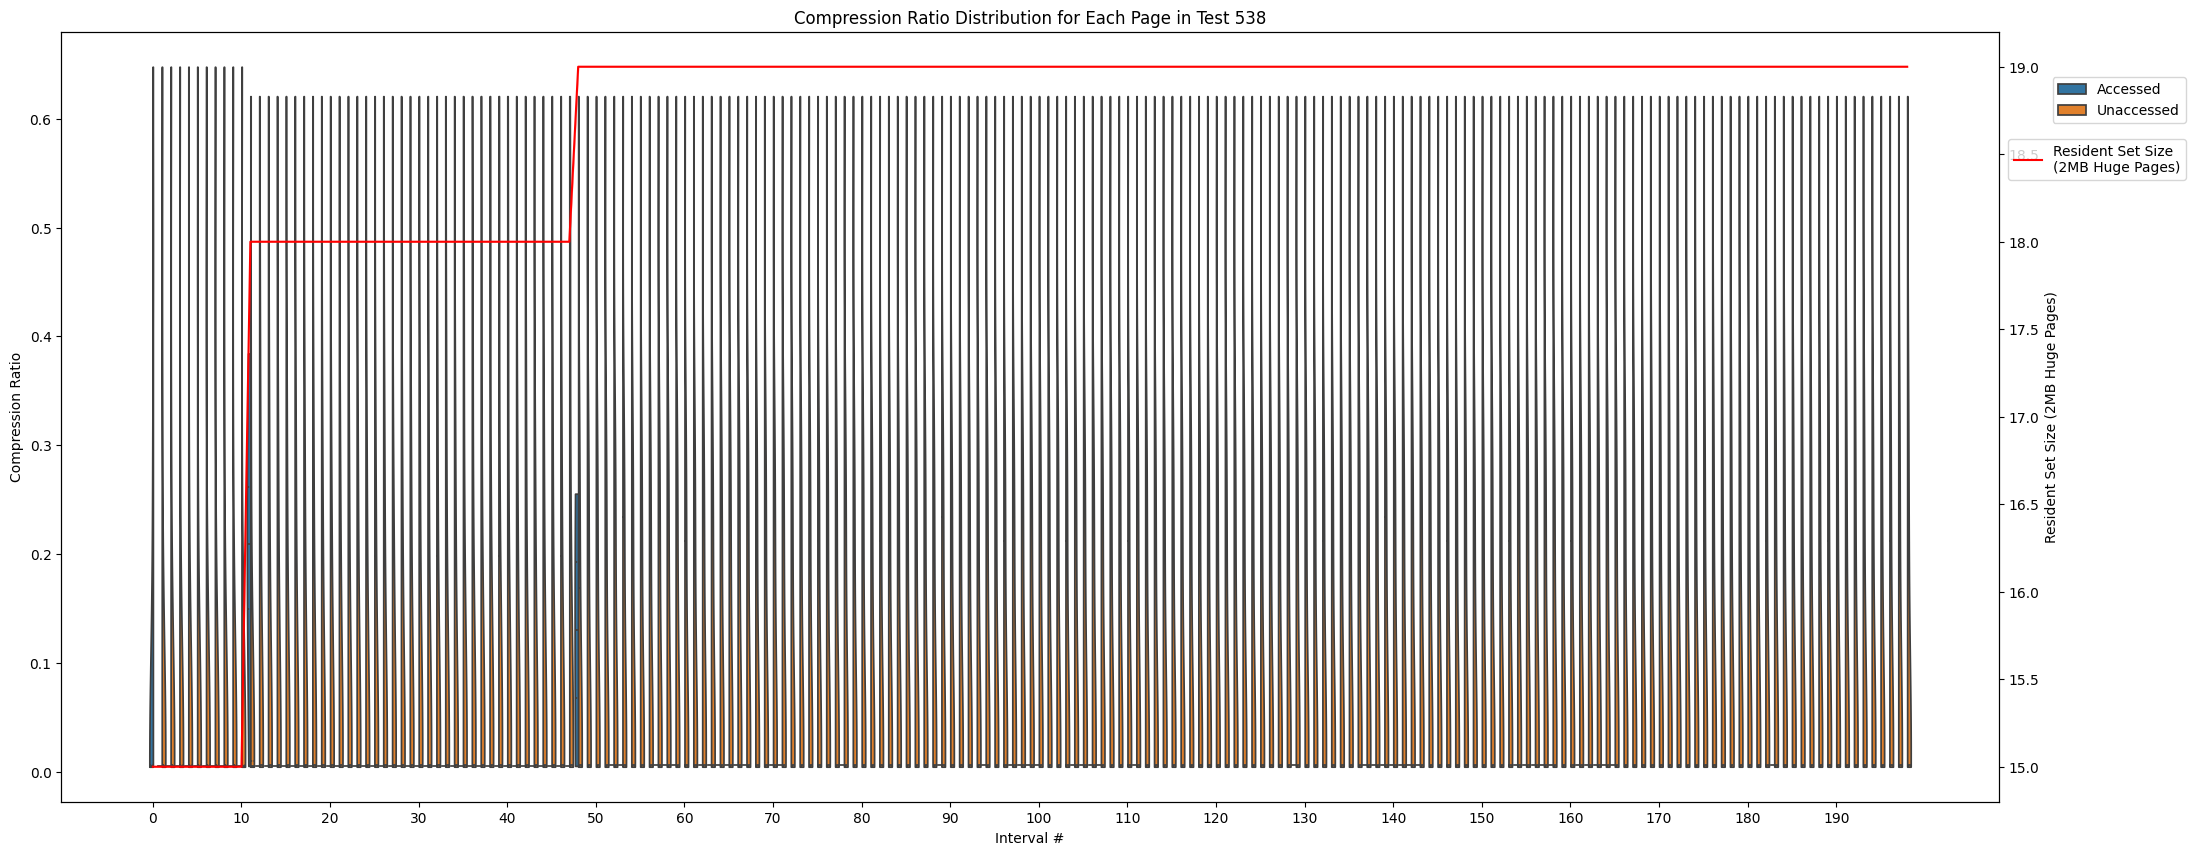

Test 544


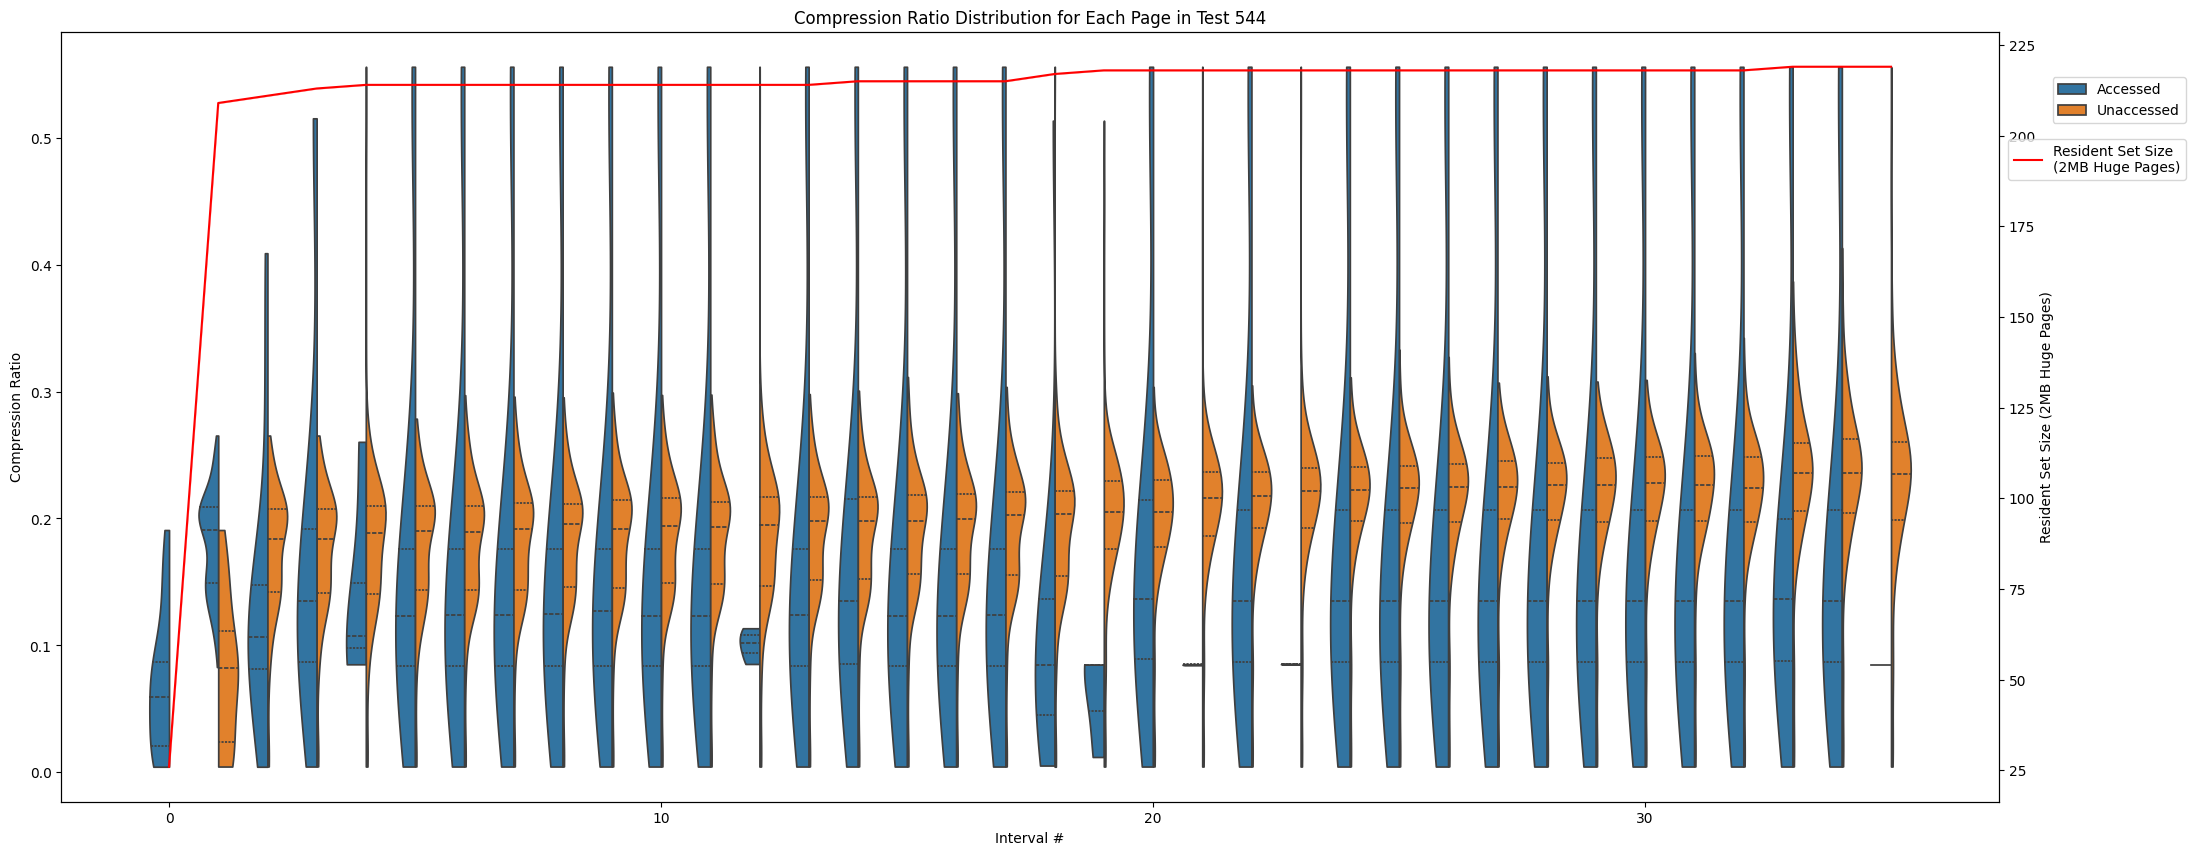

Test 548


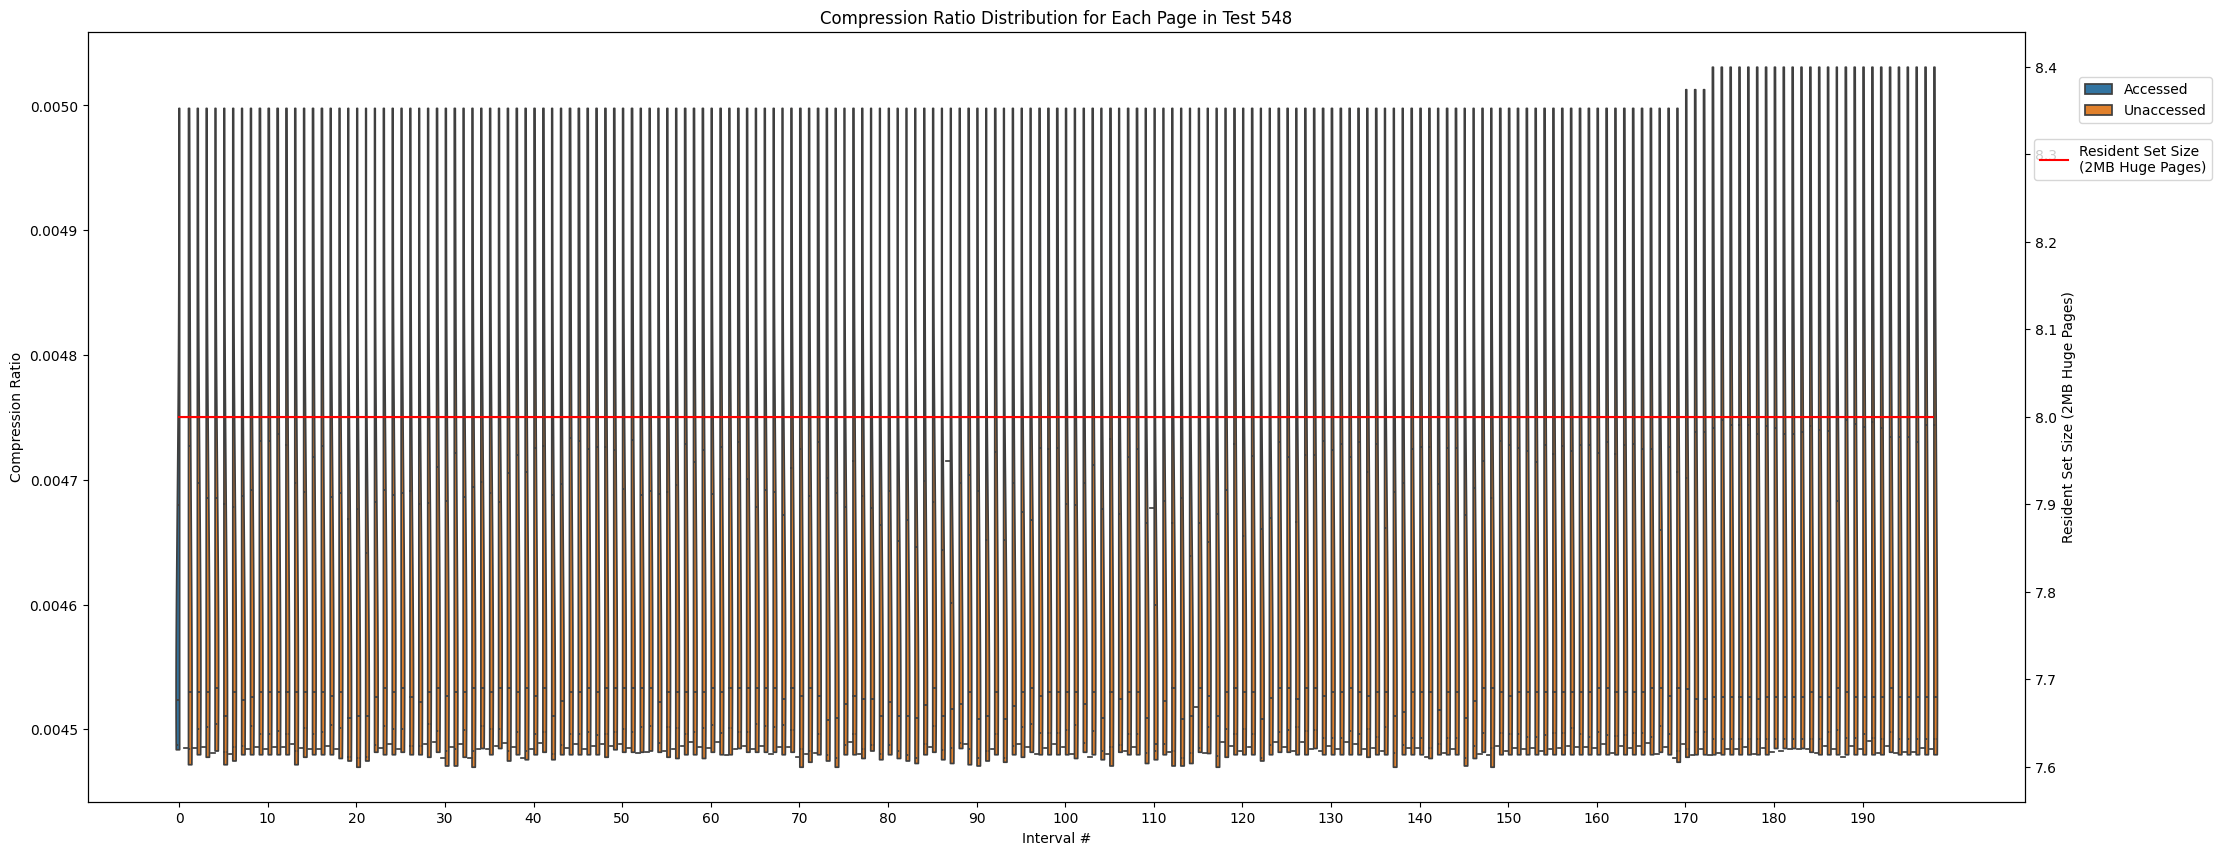

In [8]:
# Show a violin graph with the compression ratio for the pages at each interval
for test_number in all_data.keys():    # Physical size 
    
    plt.figure(figsize=(25, 10))
    print("Test", test_number)
    test_data = all_data[test_number]
    test_data = test_data.copy()
    # Truncate to first 200 intervals
    test_data = test_data[test_data["Interval #"] < 200]
    min_interval = test_data["Interval #"].min()
    test_data["Interval #"] = test_data["Interval #"] - min_interval
    max_interval = test_data["Interval #"].max()
    
    # Sum all the physical sizes for each interval
    physical_size = test_data.groupby("Interval #")["Page Size (bytes)"].sum().reset_index()
    unaccessed_physical_size = test_data[test_data["Unaccessed?"] == True].groupby("Interval #")["Page Size (bytes)"].sum().reset_index()
    

    # Show the distribution of the objects
    ax = sns.violinplot(data=test_data, cut=0, density_norm="width", x="Interval #", y="Compression Ratio (compressed/uncompressed)", split=True, hue="Unaccessed?", inner="quartile")
    handles, labels = ax.get_legend_handles_labels()
    
    plt.ylabel("Compression Ratio")
    plt.twinx()
    plt.ylabel("Resident Set Size (2MB Huge Pages)")
    sns.lineplot(data=test_data, x="Interval #", y="Live Pages", color="red", label="Resident Set Size\n(2MB Huge Pages)")
    # sns.lineplot(data=physical_size, x="Interval #", y="Physical Size (bytes)", color="blue", label="Physical Size (bytes)")
    # sns.lineplot(data=unaccessed_physical_size, x="Interval #", y="Physical Size (bytes)", color="green", label="Unaccessed Physical Size (bytes)")
    ax.legend(handles, ["Accessed", "Unaccessed"], bbox_to_anchor=(1.1, 0.95))
    plt.legend(bbox_to_anchor=(1.1, 0.87))
    plt.xlabel("Interval #")
    plt.title(f"Compression Ratio Distribution for Each Page in Test {test_number}")
    plt.xticks(np.arange(0, max_interval, 10))
    plt.show()

In [10]:
# For all tests with greater or equal to 4 intervals,
# Print the average compression ratio of accessed vs. unaccessed objects
for test_number in all_data.keys():
    test_data = all_data[test_number]
    accessed_ratio = test_data[test_data["Unaccessed?"] == False]["Compression Ratio (compressed/uncompressed)"].mean()
    unaccessed_ratio = test_data[test_data["Unaccessed?"] == True]["Compression Ratio (compressed/uncompressed)"].mean()
    print(f"Test {test_number}: Average overall compression ratio: {test_data['Compression Ratio (compressed/uncompressed)'].mean():.5}")
    print(f"Test {test_number}: Accessed compression ratio: {accessed_ratio:.5}, Unaccessed compression ratio: {unaccessed_ratio:.5}")
    
    # Print the fraction of memory unaccessed on average for all intervals
    accessed = test_data[test_data["Unaccessed?"] == False]["Page Size (bytes)"].sum()
    unaccessed = test_data[test_data["Unaccessed?"] == True]["Page Size (bytes)"].sum()
    total = accessed + unaccessed
    print(f"Test {test_number}: Accessed (ONE INTERVAL) memory fraction: {accessed / total*100:4.4}%, Unaccessed memory fraction: {unaccessed / total*100:4.4}%")
    
    # Print as a latex table row
    print(f"{test_number} & {test_data['Compression Ratio (compressed/uncompressed)'].mean():.5} & {accessed_ratio:.5} & {unaccessed_ratio:.5} & {accessed / total*100:4.4}\\% & {unaccessed / total*100:4.4}\\% \\\\")

    print()

Test 500: Average overall compression ratio: 0.070885
Test 500: Accessed compression ratio: 0.14524, Unaccessed compression ratio: 0.0693
Test 500: Accessed (ONE INTERVAL) memory fraction: 2.108%, Unaccessed memory fraction: 97.89%
500 & 0.070885 & 0.14524 & 0.0693 & 2.108\% & 97.89\% \\

Test 502: Average overall compression ratio: 0.078302
Test 502: Accessed compression ratio: 0.064037, Unaccessed compression ratio: 0.078523
Test 502: Accessed (ONE INTERVAL) memory fraction: 1.58%, Unaccessed memory fraction: 98.42%
502 & 0.078302 & 0.064037 & 0.078523 & 1.58\% & 98.42\% \\

Test 508: Average overall compression ratio: 0.11367
Test 508: Accessed compression ratio: 0.086694, Unaccessed compression ratio: 0.17938
Test 508: Accessed (ONE INTERVAL) memory fraction: 70.61%, Unaccessed memory fraction: 29.39%
508 & 0.11367 & 0.086694 & 0.17938 & 70.61\% & 29.39\% \\

Test 511: Average overall compression ratio: 0.01723
Test 511: Accessed compression ratio: 0.01515, Unaccessed compression r